In [24]:
import pandas as pd
from pandas import DataFrame
import numpy as np


In [17]:
df = pd.read_csv('./parsed_transactions.csv', index_col=False)
df['transaction_time'].head(3)
df

,id,transaction_type,transaction_id,transaction_time,transaction_amount,business_short_code,bill_ref_number,invoice_number,org_account_balance,third_party_tansaaction_id,msisdn,first_name,middle_name,last_name
0,1253,Pay Bill,07550F6DDC,20250205100412,482.0,107031,96646.0,NaN,1719.0,9ad8953d67b04cd0837ec534e120afc3,2134212610013,Robert,Christina,Lucas
1,2,Pay Bill,TDE07012MJ,20250414211355,100.0,107031,12345.0,NaN,1743.0,NaN,94c392c311d522da950619227b3361752a42042db7e1e6...,NICHOLAS,NaN,NaN
2,3,Pay Bill,317A7A22A8,20250123164546,595.0,107031,10748.0,NaN,1327.0,1a28f097c7b4481193c4691452fd52a8,2964225487729,Sonia,Cynthia,Harvey
3,4,Pay Bill,3B094B113D,20250131221849,85.0,107031,38482.0,NaN,4331.0,f48a3969db7f4250bdfe8d358f602422,7988867534902,John,Alyssa,Warren
4,5,Pay Bill,FD1E5A06AD,20250110235303,672.0,107031,13820.0,NaN,3185.0,078dfb9d05094bc98172d77375fd28b4,1977556613180,Sarah,William,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,3017,Buy Goods,42FA9D7B44,20250121203737,169.0,107031,83428.0,NaN,2492.0,0414bb0467a9498aac6a9ab8b3cd375f,0247890062542,Vickie,Rachel,Stewart
3016,3018,Buy Goods,BC90B3B3E0,20250124103251,826.0,107031,73131.0,NaN,1105.0,d7b1012f5f974a3cb2d644f61ee354c4,2101829818363,Eric,Tammy,Frank
3017,3019,Buy Goods,1019BE827C,20250130180134,724.0,107031,56919.0,NaN,3147.0,ae6f6b230ebb4da4b604ce9f0770994b,2059798017379,Emily,Rodney,Kelley
3018,3020,Buy Goods,2BCE56344F,20250320210701,401.0,107031,45456.0,NaN,1180.0,4b3cd39c19e0402bba1bb33a73b9159c,8167489577858,Melanie,Amanda,Price


In [14]:
def parse_time(df: DataFrame) -> DataFrame:
    df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%Y%m%d%H%M%S')
    return df['transaction_time'].head()

parse_time(df)


0   2025-02-05 10:04:12
1   2025-04-14 21:13:55
2   2025-01-23 16:45:46
3   2025-01-31 22:18:49
4   2025-01-10 23:53:03
Name: transaction_time, dtype: datetime64[ns]

In [27]:
def get_repeat_customers(df: pd.DataFrame) -> pd.DataFrame:
    now = pd.Timestamp.now()
    grouped = df.groupby('msisdn').agg(
        total_transactions=('transaction_id', 'count'),
        total_spend=('transaction_amount', 'sum'),
        avg_spend=('transaction_amount', 'mean'),
        last_seen=('transaction_time', 'max')
    ).reset_index()

    grouped['days_since_last'] = (now - grouped['last_seen']).dt.days
    grouped['is_churned'] = grouped['days_since_last'] > 30
    grouped['churn_score'] = grouped['days_since_last'] / 60.0  # normalize
    grouped['churn_score'] = grouped['churn_score'].clip(0, 1)
    grouped['loyalty_score'] = np.log1p(grouped['total_transactions']) * (1 - grouped['churn_score'])

    grouped = grouped.sort_values(by='loyalty_score', ascending=False)

    return grouped
parse_time(df)
get_repeat_customers(df)


,msisdn,total_transactions,total_spend,avg_spend,last_seen,days_since_last,is_churned,churn_score,loyalty_score
238,7675667210139,185,389445.0,2105.108108,2025-04-15 19:59:15,-1,False,0.000000,5.225747
98,2869932187643,181,326448.0,1803.580110,2025-04-15 10:46:10,0,False,0.000000,5.204007
315,9960016016079,175,344521.0,1968.691429,2025-04-15 20:19:46,-1,False,0.000000,5.170484
71,2059798017379,173,396066.0,2289.398844,2025-04-14 09:49:25,1,False,0.016667,5.073071
128,3868315518393,164,322375.0,1965.701220,2025-04-14 09:03:43,1,False,0.016667,5.020846
...,...,...,...,...,...,...,...,...,...
146,4286258264184,1,32.0,32.000000,2025-01-13 07:54:55,92,True,1.000000,0.000000
79,2285977378467,1,194.0,194.000000,2025-01-24 05:50:08,81,True,1.000000,0.000000
68,1977556613180,1,672.0,672.000000,2025-01-10 23:53:03,94,True,1.000000,0.000000
276,8812016686140,1,593.0,593.000000,2025-01-18 10:06:27,87,True,1.000000,0.000000


In [ ]:
def cluster_customers_fcm(self, df: DataFrame) -> DataFrame:
    return df

In [ ]:

def predict_customer_lifetime_value(self, df: DataFrame) -> DataFrame:
    return df


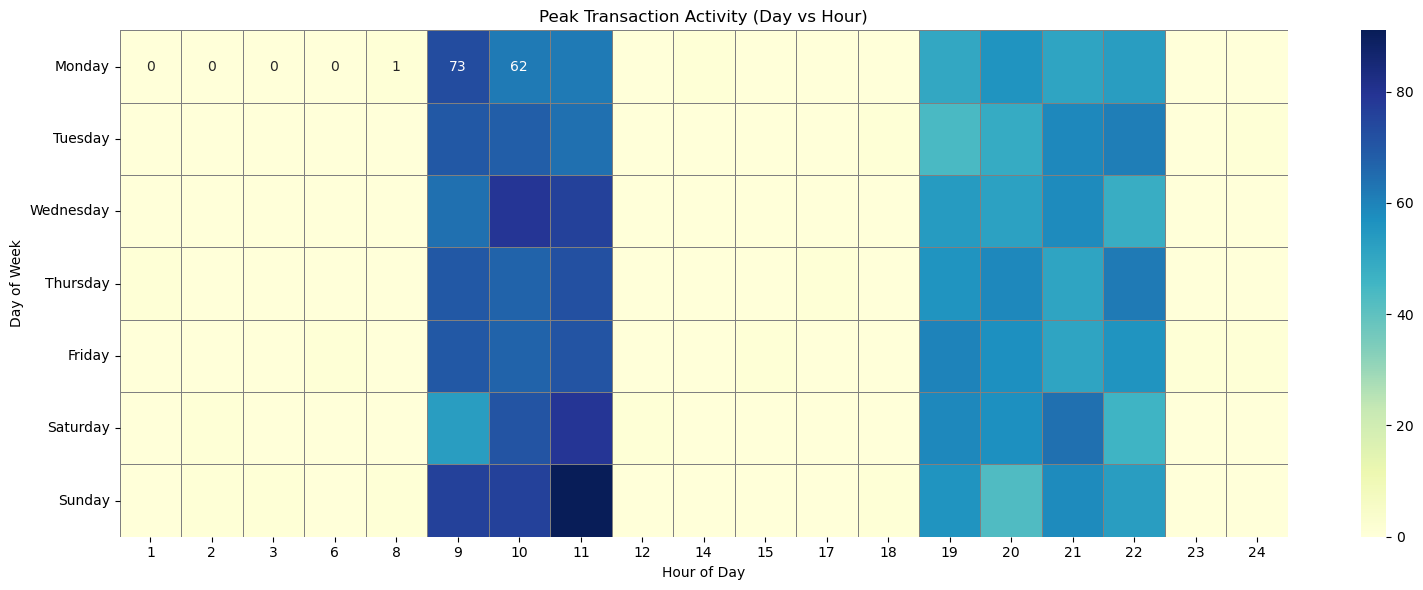

In [34]:
def get_peak_activity(df: pd.DataFrame) -> pd.DataFrame:
    # Extract hour and day of week
    df['hour'] = df['transaction_time'].dt.hour + 1
    df['day_of_week'] = df['transaction_time'].dt.day_name()

    # Create pivot table: rows = days, columns = hours, values = transaction counts
    heatmap_df = df.pivot_table(
        index='day_of_week',
        columns='hour',
        values='transaction_id',
        aggfunc='count',
        fill_value=0
    )

    # Optional: order days for better readability
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_df = heatmap_df.reindex(ordered_days)

    return heatmap_df

import seaborn as sns
import matplotlib.pyplot as plt

def plot_peak_activity_heatmap(df: pd.DataFrame):
    heatmap_df = get_peak_activity(df)

    plt.figure(figsize=(16, 6))
    sns.heatmap(
        heatmap_df,
        cmap="YlGnBu",
        linewidths=0.5,
        linecolor='gray',
        annot=True,
        fmt='d'
    )
    plt.title("Peak Transaction Activity (Day vs Hour)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.tight_layout()
    plt.show()



parse_time(df)
get_peak_activity(df)
plot_peak_activity_heatmap(df)


In [16]:
def get_total_transactions(df: DataFrame) -> int:
    return len(df)   
    
get_total_transactions(df)


3020

In [19]:
def compute_transaction_volume(self, df: DataFrame) -> float:
    return df['transaction_amount'].sum()


compute_transaction_volume(df)

6854217.0

In [48]:
def compute_timeseries_trends(df: DataFrame, freq: str = 'W') -> DataFrame:
    """
    Computes timeseries trends grouped by a given frequency.
    
    Args:
        df: DataFrame with 'transaction_time' and 'transaction_amount'.
        freq: Resampling frequency - 'D' (day), 'W' (week), 'M' (month)
        
    Returns:
        DataFrame with date index and aggregated metrics.
    """
    df = df.copy()
    df['transaction_time'] = pd.to_datetime(df.get('transaction_time', pd.Timestamp.now()))
    df['transaction_amount'] = df.get('transaction_amount', 0)
    df['transaction_id'] = df.get('transaction_id', range(len(df)))

    df['transaction_time'] = pd.to_datetime(df['transaction_time'])
    df.set_index('transaction_time', inplace=True)

    trends = df.resample(freq).agg({
        'transaction_id': 'count',
        'transaction_amount': 'sum'
    }).rename(columns={
        'transaction_id': 'total_transactions',
        'transaction_amount': 'total_amount'
    })

    return trends.reset_index()
parse_time(df)
daily_trends = compute_timeseries_trends(df, freq='D')
weekly_trends = compute_timeseries_trends(df, freq='W')
monthly_trends = compute_timeseries_trends(df, freq='M')

daily_trends,weekly_trends,monthly_trends



(    transaction_time  total_transactions  total_amount
 0         2025-01-01                  28      128382.0
 1         2025-01-02                  29       14909.0
 2         2025-01-03                  32      113688.0
 3         2025-01-04                  28       34350.0
 4         2025-01-05                  32       74050.0
 ..               ...                 ...           ...
 100       2025-04-11                  26       49979.0
 101       2025-04-12                  28       98602.0
 102       2025-04-13                  38       17485.0
 103       2025-04-14                  24       13152.0
 104       2025-04-15                   6       37177.0
 
 [105 rows x 3 columns],
    transaction_time  total_transactions  total_amount
 0        2025-01-05                 149      365379.0
 1        2025-01-12                 196      275138.0
 2        2025-01-19                 192      510015.0
 3        2025-01-26                 206      562200.0
 4        2025-02-02      